In [1]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.LRGSG import Lattice3D, flip_to_positive_majority_adapted
from LRGSG_package.LRGSG import move_to_rootf
#
move_to_rootf()

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


### Clusters distribution

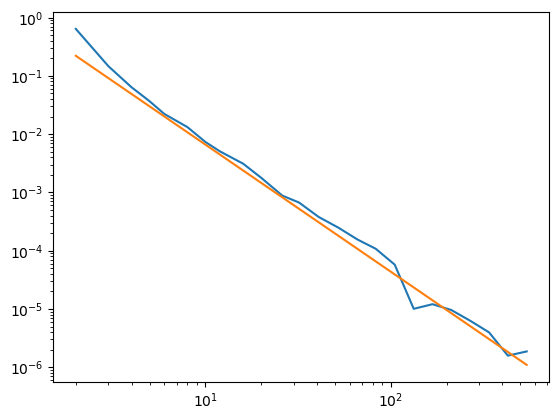

In [14]:
side = 20
pflip = 0.17
navg = 50
clusterLen = []
#
for _ in range(navg):
    l = Lattice3D(dim=(side, side, side), pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_k_eigvV()
    l.load_eigV_on_graph(binarize=True)
    G_pos, G_neg = l.group_nodes_by_kv(f"eigV0", -1)
    clusters = sorted(list(nx.connected_components(G_neg)), 
                      key=lambda x: len(x), reverse=True)
    clusterLen.extend(list(map(lambda x: len(x), clusters)))
    # print(np.log10(np.abs(l.eigV[0])).min(), 
    #       np.log10(np.abs(l.eigV[0])).max(), sep='\n')
#
pdf = powerlaw.pdf(np.array(clusterLen))
x, y = pdf
plt.plot(x[1:], y)
plt.plot(x[1:], x[1:]**(-2.18))
plt.yscale('log')
plt.xscale('log')

### Validation

In [10]:
l = Lattice3D((9, 9, 9), 'sc', 
              pbc=True, 
              pflip=0.2,
              theta=np.pi/7, phi=np.pi/8,
              with_positions=True)
l.flip_random_fract_edges()

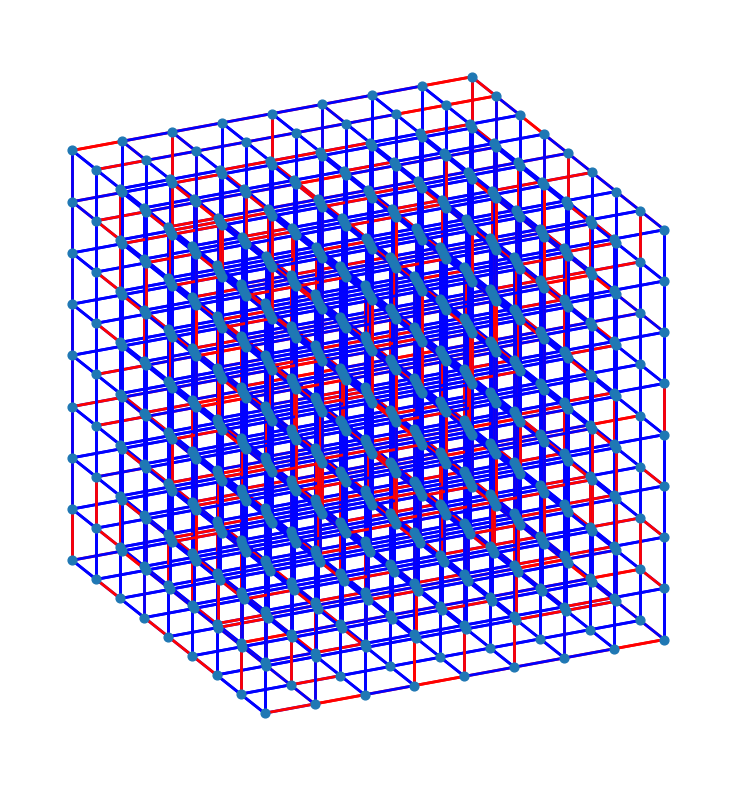

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
# l._set_positions(np.pi/3, np.pi/6)
colors = ['blue' if l.G[u][v]['weight'] == 1 else 'r' for u, v in l.G.edges()]
nx.draw(l.G, pos=l.get_node_pos(), edge_color=colors, cmap='red_blue', width=2, node_size=40, )

In [ ]:
degree_count = {node: 0 for node in l.G.nodes()}

# Iterate over all edges in the graph
for u, v, data in l.G.edges(data=True):
    # Check if the edge is of the desired type
    if data.get('type') == 'link':
        # If so, increment the degree count for both nodes connected by this edge
        degree_count[u] += 1
        degree_count[v] += 1

# degree_count now contains the degree of each node based on type 1 links only
print(np.where(np.array(list(degree_count.values())) <8)[0])

In [ ]:
list(degree_count.values())

In [ ]:
list(l.G.nodes())

In [ ]:
np.array(list(l.G.nodes))[np.where(np.array(list(degree_count.values())) != 8)[0]]

In [ ]:
dict(l.G.degree()).values()

In [ ]:
import numpy as np
import networkx as nx
from itertools import product

class LatticeGenerator:
    def __init__(self, dim, pbc=True):
        self.dim = dim
        self.pbc = pbc

    def _wrap_coordinate(self, coord):
        """Wrap coordinates according to PBC and lattice dimensions."""
        return tuple(c % d for c, d in zip(coord, self.dim))

    def _generate_fcc_lattice(self):
        G = nx.Graph()
        
        # Offsets for FCC lattice to include face-centered points
        fcc_offsets = [(0, 0, 0), (0.5, 0.5, 0), (0.5, 0, 0.5), (0, 0.5, 0.5)]

        # Generate all nodes, considering PBC for wrapping
        nodes = set(self._wrap_coordinate((x + ox, y + oy, z + oz))
                    for x, y, z in product(range(self.dim[0]), range(self.dim[1]), range(self.dim[2]))
                    for ox, oy, oz in fcc_offsets)

        G.add_nodes_from(nodes)

        # Pre-calculate wrapped neighbors for each node considering PBC
        node_list = list(G.nodes())
        for nd in node_list:
            for ox, oy, oz in fcc_offsets:
                for dx, dy, dz in [(-0.5, -0.5, 0), (-0.5, 0.5, 0), (0.5, -0.5, 0), (0.5, 0.5, 0),
                                   (-0.5, 0, -0.5), (-0.5, 0, 0.5), (0.5, 0, -0.5), (0.5, 0, 0.5),
                                   (0, -0.5, -0.5), (0, -0.5, 0.5), (0, 0.5, -0.5), (0, 0.5, 0.5)]:
                    # Wrap neighbor coordinates considering PBC
                    neighbor = self._wrap_coordinate((nd[0] + ox + dx, nd[1] + oy + dy, nd[2] + oz + dz))
                    if neighbor in nodes and neighbor != nd:
                        G.add_edge(nd, neighbor)

        return G

# Example usage
dim = (4, 4, 4)  # Specify dimensions of the FCC lattice
lattice_gen = LatticeGenerator(dim)
G = lattice_gen._generate_fcc_lattice()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


In [ ]:
dict(G.degree()).values()